In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
import re

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database

con = psycopg2.connect("dbname='doctordb' user='cathy'")

## Read in map between rxcui and hcpcs_codes

In [3]:
rxcui_hcpcs_df = pd.read_csv("05_rxcui_hcpcs_map_breast.csv")

In [56]:
rxcui_hcpcs_df.head()

,rxcui_in,drug_name,keywords_indication_desc,hcpcs_code,hcpcs_description
0,632,mitomycin,breast,J9280,"injection, mitomycin, 5 mg"
1,2555,cisplatin,breast,J9060,"injection, cisplatin, powder or solution, 10 mg"
2,3002,cyclophosphamide,breast,J9070,"cyclophosphamide, 100 mg"
3,3639,doxorubicin,breast,J9000,"injection, doxorubicin hydrochloride, 10 mg"
4,3639,doxorubicin,breast,Q2050,"injection, doxorubicin hydrochloride, liposoma..."


## Read in payments claims table
merge `payments` with `rxcui_hcpcs_df` on 'hcpcs_code'

In [4]:
q = "SELECT * FROM payments WHERE provider_type = 'Medical Oncology'"
payments = pd.read_sql_query(q, con=con)

In [58]:
## Subset payments to drugs only
payments_alldrugs = payments.query("hcpcs_drug_indicator=='Y'")
payments_alldrugs.shape

(13025, 26)

In [65]:
## merge payments/claims (only drugs) with rxcui/breast indicator

payments_rxcui_df = (payments_alldrugs[['npi','hcpcs_code','line_srvc_cnt','bene_unique_cnt','bene_day_srvc_cnt',
                               'average_submitted_chrg_amt','average_medicare_standard_amt']].
                     merge(rxcui_hcpcs_df.drop_duplicates('hcpcs_code'), on='hcpcs_code', how='left', sort=False))

payments_rxcui_df.shape

(13025, 11)

In [66]:
payments_rxcui_df.head()

,npi,hcpcs_code,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_submitted_chrg_amt,average_medicare_standard_amt,rxcui_in,drug_name,keywords_indication_desc,hcpcs_description
0,1003019571,J1100,808.0,18.0,75.0,1.0,0.10,NaN,NaN,NaN,NaN
1,1003019571,J1200,28.0,11.0,28.0,4.0,0.48,NaN,NaN,NaN,NaN
2,1003019571,J1626,500.0,12.0,50.0,43.0,0.34,NaN,NaN,NaN,NaN
3,1003807645,J0641,23400.0,13.0,32.0,4.0,1.37,NaN,NaN,NaN,NaN
4,1003807645,J0885,8510.0,80.0,210.0,24.0,8.99,NaN,NaN,NaN,NaN


In [67]:
## Did any doctors not prescribe a breast drug?
payments_rxcui_df['rxcui_in'].isnull().any()

True

In [68]:
## How many claims not explicitly for breast cancer drugs?
payments_rxcui_df['rxcui_in'].isnull().sum()

9734

In [69]:
## Number of rows explicitly for breast cancer drugs:
payments_rxcui_df.shape[0] - payments_rxcui_df['rxcui_in'].isnull().sum()

3291

How many distinct doctors are in payments_rxcui_df, i.e. doctors who made a claim for a medicare drug?

In [70]:
payments_rxcui_df.drop_duplicates('npi').shape

(1056, 11)

Out of all doctors who prescribed a drug (hcpcs_indicator == 'Y'), how many prescribed at least one breast cancer drug?

In [71]:
payments_rxcui_df.query("~rxcui_in.isnull()").drop_duplicates('npi').shape

(759, 11)

Out of the doctors who prescribed a breast cancer drug, how many different types of breast cancer drugs did each prescribe?

In [72]:
breast_drugs_cnt_per_npi = payments_rxcui_df.query("~rxcui_in.isnull()").groupby('npi').size()

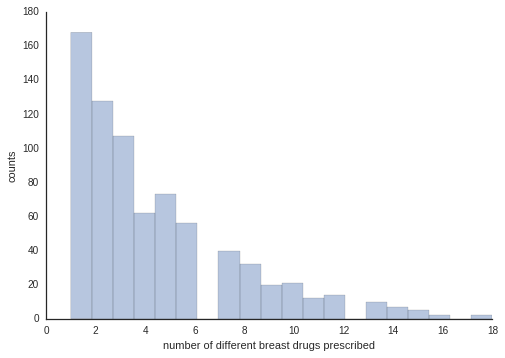

In [73]:
## distribution of number of different types of breast drugs prescribed by npi
g = sns.distplot(breast_drugs_cnt_per_npi, kde=False)
g.set(xlabel='number of different breast drugs prescribed', ylabel='counts')
sns.despine()

Out of the doctors who prescribed a breast cancer drug, how many total unique beneficiaries of these breast drugs did each have?  Note, this number is probably higher than the actual total number of breast cancer patients seen by the doctor since a patient may be a beneficiary of multiple breast-drugs under one doctor.

In [74]:
breast_patients_per_npi = (payments_rxcui_df.
                           query("~rxcui_in.isnull()").
                           groupby('npi')['bene_unique_cnt'].
                           sum().
                           reset_index().
                           rename(columns={'bene_unique_cnt':'breast_bene_cnt'}))

breast_patients_per_npi.head()

,npi,breast_bene_cnt
0,1003807645,229.0
1,1003809435,51.0
2,1003828823,141.0
3,1003859679,346.0
4,1003864380,71.0


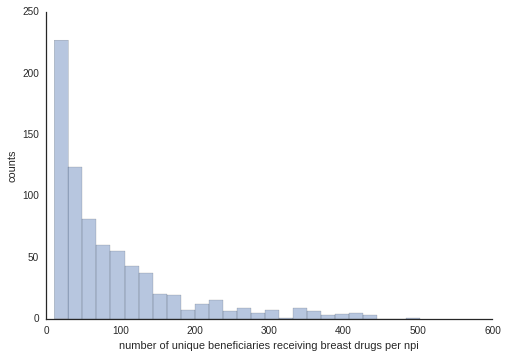

In [75]:
## distribution of number of breast patients per npi
g = sns.distplot(breast_patients_per_npi.breast_bene_cnt, kde=False)
g.set(xlabel='number of unique beneficiaries receiving breast drugs per npi', ylabel='counts')
sns.despine()

### For doctors who prescribed a breast drug, what percentage of the total drug beneficiary count is made up by beneficiaries of a breast drug?

In [76]:
## total_drug_benes is NOT the total number of distinct beneficiaries of drug claims 
total_drug_benes = (payments.query("hcpcs_drug_indicator=='Y'").
                    groupby('npi')['bene_unique_cnt'].
                    sum().
                    reset_index().
                   rename(columns={'bene_unique_cnt':'total_drug_bene_cnt'}))

total_drug_benes.head()

,npi,total_drug_bene_cnt
0,1003019571,41.0
1,1003807645,946.0
2,1003809435,425.0
3,1003828823,652.0
4,1003859679,1272.0


In [77]:
total_drug_benes.shape

(1056, 2)

In [78]:
breast_patient_fraction = (breast_patients_per_npi.
                           merge(total_drug_benes, on='npi', how='right').
                           assign(breast_frac = lambda x: x.breast_bene_cnt / x.total_drug_bene_cnt))

breast_patient_fraction.head()

,npi,breast_bene_cnt,total_drug_bene_cnt,breast_frac
0,1003807645,229.0,946.0,0.242072
1,1003809435,51.0,425.0,0.120000
2,1003828823,141.0,652.0,0.216258
3,1003859679,346.0,1272.0,0.272013
4,1003864380,71.0,348.0,0.204023


In [79]:
## Some npi's had no breast cnts. sanity check this is true
breast_patient_fraction['breast_frac'].isnull().sum()

297

In [88]:
## replace rows with null breast_bene_cnt and breast_frac with 0
breast_patient_fraction.loc[breast_patient_fraction.breast_bene_cnt.isnull(), 'breast_bene_cnt'] = 0
breast_patient_fraction.loc[breast_patient_fraction.breast_frac.isnull(), 'breast_frac'] = 0

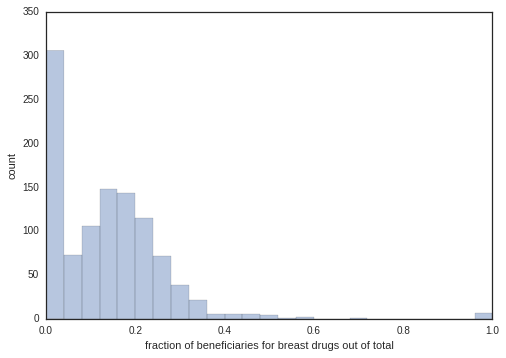

In [81]:
g = sns.distplot(breast_patient_fraction['breast_frac'], kde=False)
g.set(xlabel='fraction of beneficiaries for breast drugs out of total', ylabel='count')

[(0, 150),

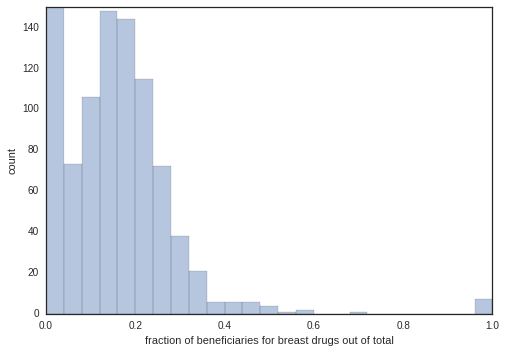

In [82]:
## replot with smaller yaxis limit
g = sns.distplot(breast_patient_fraction['breast_frac'], kde=False)
g.set(xlabel='fraction of beneficiaries for breast drugs out of total', ylabel='count', ylim=(0,150))

## t-SNE plot doctors in drug-space, overlaid with color according to breast attributes

In [83]:
by_npi = (payments.
          loc[payments.hcpcs_drug_indicator=='Y',['npi','hcpcs_code','line_srvc_cnt']].
          pivot(index='npi', values = 'line_srvc_cnt', columns='hcpcs_code').
          fillna(value=0))
         
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1056
[t-SNE] Computed conditional probabilities for sample 1056 / 1056
[t-SNE] Mean sigma: 44.173597
[t-SNE] Iteration 25: error = 0.9551014, gradient norm = 0.0100483
[t-SNE] Iteration 50: error = 0.8478842, gradient norm = 0.0093686
[t-SNE] Iteration 75: error = 0.5760345, gradient norm = 0.0058276
[t-SNE] Iteration 100: error = 0.5507403, gradient norm = 0.0059530
[t-SNE] Error after 100 iterations with early exaggeration: 0.550740
[t-SNE] Iteration 125: error = 0.4915922, gradient norm = 0.0057868
[t-SNE] Iteration 150: error = 0.4857209, gradient norm = 0.0050797
[t-SNE] Iteration 175: error = 0.4793441, gradient norm = 0.0054414
[t-SNE] Iteration 200: error = 0.4811062, gradient norm = 0.0045308
[t-SNE] Iteration 225: error = 0.4754431, gradient norm = 0.0055525
[t-SNE] Iteration 250: error = 0.4825531, gradient norm = 0.0047118
[t-SNE] I

In [89]:
## make color codes 
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(breast_patient_fraction))

color_codes.shape

(1056, 4)

In [90]:
color_codes.head()

,npi,breast_bene_cnt,total_drug_bene_cnt,breast_frac
0,1003019571,0.0,41.0,0.000000
1,1003807645,229.0,946.0,0.242072
2,1003809435,51.0,425.0,0.120000
3,1003828823,141.0,652.0,0.216258
4,1003859679,346.0,1272.0,0.272013


In [120]:
## what are the aggregate stats per column?
color_codes.iloc[:,1:4].describe()

,breast_bene_cnt,total_drug_bene_cnt,breast_frac
count,1056.000000,1056.000000,1056.000000
mean,62.940341,364.228220,0.135479
std,85.683199,376.017911,0.131971
min,0.000000,11.000000,0.000000
25%,0.000000,99.000000,0.000000
50%,30.500000,244.000000,0.130350
75%,88.000000,505.250000,0.205882
max,502.000000,2136.000000,1.000000


In [119]:
## aggregate stats dropping rows with 0 breast_bene_cnt
color_codes.query('breast_bene_cnt>0').iloc[:,1:4].describe()

,breast_bene_cnt,total_drug_bene_cnt,breast_frac
count,759.000000,759.000000,759.000000
mean,87.569170,474.393939,0.188492
std,89.769891,389.269625,0.119308
min,11.000000,11.000000,0.019169
25%,26.000000,205.000000,0.120327
50%,53.000000,349.000000,0.170370
75%,114.500000,620.000000,0.231689
max,502.000000,2136.000000,1.000000


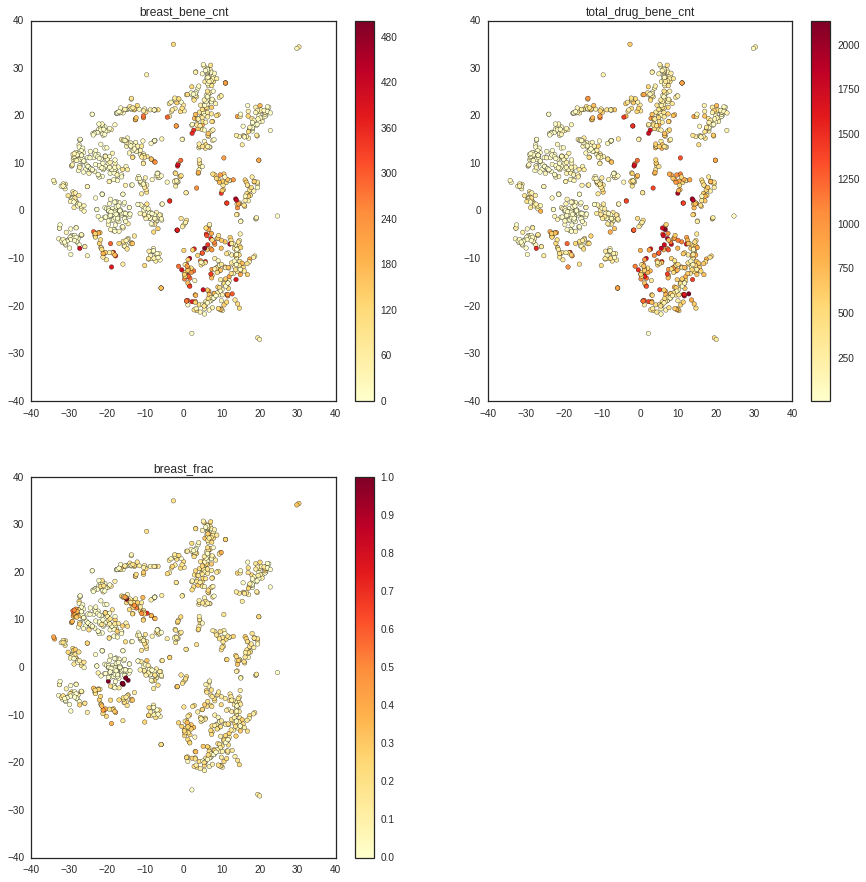

In [94]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)

for i in range(1, color_codes.shape[1]):
    plt.subplot(2,2, i)
    sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                     c=color_codes.iloc[:, i], cmap='YlOrRd')
    plt.colorbar(sc)
    plt.title(color_codes.columns.values[i])

In [96]:
## Correlations between the 3 breast_cnt, breast_frac, and total_drug_bene_cnt?
corr = breast_patient_fraction.iloc[1:3].corr()
corr

,breast_bene_cnt,total_drug_bene_cnt,breast_frac
breast_bene_cnt,1.0,1.0,1.0
total_drug_bene_cnt,1.0,1.0,1.0
breast_frac,1.0,1.0,1.0


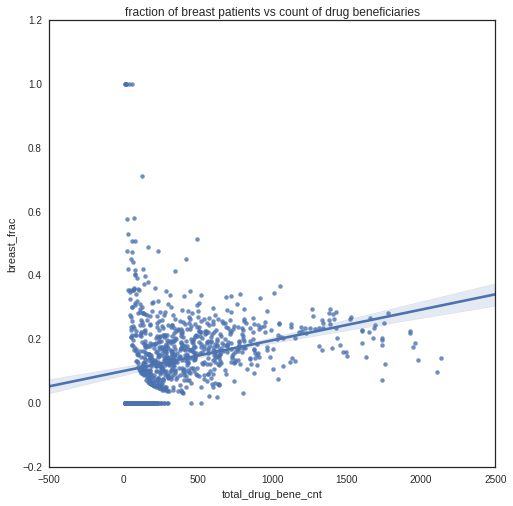

In [101]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

g = sns.regplot(x="total_drug_bene_cnt", y="breast_frac", data=breast_patient_fraction, fit_reg=True)
g.set(title='fraction of breast patients vs count of drug beneficiaries')

[(0, 600), (0, 2500), <matplotlib.text.Text at 0x7f2eb5721cf8>]

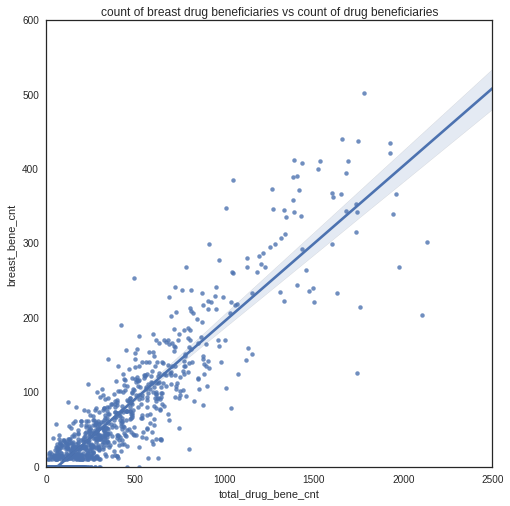

In [104]:
g = sns.regplot(x="total_drug_bene_cnt", y="breast_bene_cnt", data=breast_patient_fraction, fit_reg=True)
g.set(title='count of breast drug beneficiaries vs count of drug beneficiaries', xlim=(0,2500),ylim=(0,600))

## Look at individual data points/ doctors

In [110]:
## Who has a breast_frac = 1?

(breast_patient_fraction.
 query('breast_frac == 1').
 merge(payments[['npi','nppes_provider_last_org_name','nppes_provider_first_name',
                 'nppes_provider_city','nppes_provider_state']], on='npi', how='inner').
 drop_duplicates('npi'))

,npi,breast_bene_cnt,total_drug_bene_cnt,breast_frac,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state
0,1114016284,16.0,16.0,1.0,DAVIS,ALLAN,LANCASTER,PA
16,1174571699,11.0,11.0,1.0,SCHIFF,RON,TAMPA,FL
43,1346289824,20.0,20.0,1.0,BOSSERMAN,LINDA,RANCHO CUCAMONGA,CA
50,1366599219,19.0,19.0,1.0,JONES,CATHERINE,MERCED,CA
65,1548298656,39.0,39.0,1.0,GROSS,MITCHELL,BEVERLY HILLS,CA
74,1699722850,57.0,57.0,1.0,EISENBERGER,MARIO,BALTIMORE,MD
82,1801950704,11.0,11.0,1.0,BELTRAN,HIMISHA,NEW YORK,NY


These doctors have an extremely low total_drug_bene_cnt compared to the rest of the population.

In [125]:
## What are the doctors with the highest breast_bene_cnt?
(breast_patient_fraction.
 merge(payments[['npi','nppes_provider_last_org_name','nppes_provider_first_name', 'nppes_provider_mi',
                 'nppes_provider_city','nppes_provider_state']], on='npi', how='inner').
 drop_duplicates('npi').
 sort_values('breast_bene_cnt', ascending=False)).head(10)

,npi,breast_bene_cnt,total_drug_bene_cnt,breast_frac,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_provider_city,nppes_provider_state
24479,1659352383,502.0,1781.0,0.281864,BROWN,RICHARD,H,SARASOTA,FL
27626,1730136854,440.0,1656.0,0.265700,NAZHA,NAIM,T,NORTHFIELD,NJ
3260,1083693154,438.0,1748.0,0.250572,SCHREEDER,MARSHALL,T,HUNTSVILLE,AL
1608,1043474042,435.0,1927.0,0.225739,LIU,JIJUN,None,PEORIA,IL
32357,1871593434,422.0,1925.0,0.219221,GEOFFROY,FRANCOIS,J,PEORIA,IL
22840,1619959525,412.0,1390.0,0.296403,WILDER,DIANE,D,LITTLE ROCK,AR
35760,1972577930,411.0,1532.0,0.268277,SULTANI,MTANIUS,A,CLARKSDALE,MS
21028,1558380295,411.0,1690.0,0.243195,GREENWALD,DAVID,W,KINGSTON,PA
16063,1437116985,408.0,1431.0,0.285115,PARIPATI,HARSHITA,R,SCOTTSDALE,AZ
1977,1053372649,400.0,1521.0,0.262985,MATTAR,BASSAM,I,WICHITA,KS


### Richard H Brown has had a board action against him for negligent care! (but not Haim Nazha or Marshall Schreeder)